In [1]:
import numpy as np
from IPython.display import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
Image(url='nba-karl-malone.gif')

In [2]:
player_totals=pd.read_csv('./data/Player Totals.csv')
player_season_info=pd.read_csv('./data/Player Season Info.csv')
player_career_info=pd.read_csv('./data/Player Career Info.csv')
player_award_shares=pd.read_csv('./data/Player Award Shares.csv')
all_star=pd.read_csv('./data/All-Star Selections.csv')
advanced=pd.read_csv('./data/Advanced.csv')
end_of_season=pd.read_csv('./data/End of Season Teams.csv')

hof=player_career_info.drop(['birth_year','num_seasons'],axis=1)
player_names_and_seasons=hof[['player','first_seas','last_seas','player_id']]

In [3]:
seasons = np.flip(player_totals.season.unique())
seasons_leaderboards = {}
for season in seasons:
    season_top10s = {'pts': player_totals[player_totals['season'] == season].sort_values(by=['pts']).tail(10),
                     'reb': player_totals[player_totals['season'] == season].sort_values(by=['trb']).tail(10),
                     'ast': player_totals[player_totals['season'] == season].sort_values(by=['ast']).tail(10),
                     'min': player_totals[player_totals['season'] == season].sort_values(by=['mp']).tail(10),
                     'stl': player_totals[player_totals['season'] == season].sort_values(by=['stl']).tail(10),
                     'blk': player_totals[player_totals['season'] == season].sort_values(by=['blk']).tail(10)}
    seasons_leaderboards[season] = season_top10s

In [4]:
leaderboard_points=[]
for i in range(len(player_names_and_seasons)):
    x=0
    if i%250==0:
        print(i)
    for season in range(player_names_and_seasons.iloc[i].first_seas,player_names_and_seasons.iloc[i].last_seas+1):
        top10_pts = seasons_leaderboards[season]['pts']
        top10_reb = seasons_leaderboards[season]['reb']
        top10_ast = seasons_leaderboards[season]['ast']
        top10_min = seasons_leaderboards[season]['min']
        top10_stl = seasons_leaderboards[season]['stl']
        top10_blk = seasons_leaderboards[season]['blk']
        for j in range(9,-1,-1):
            if top10_pts.iloc[j].player_id == player_names_and_seasons.iloc[i].player_id:
                x+=(5 + j/2)
            if top10_reb.iloc[j].player_id == player_names_and_seasons.iloc[i].player_id:
                x+=(5 + j/2)
            if top10_ast.iloc[j].player_id == player_names_and_seasons.iloc[i].player_id:
                x+=(5 + j/2)
            if top10_min.iloc[j].player_id == player_names_and_seasons.iloc[i].player_id:
                x+=(5 + j/2)
            if top10_stl.iloc[j].player_id == player_names_and_seasons.iloc[i].player_id:
                x+=(5 + j/2)
            if top10_blk.iloc[j].player_id == player_names_and_seasons.iloc[i].player_id:
                x+=(5 + j/2)
    leaderboard_points.append(x)
    
hof['Leaderboard points']=leaderboard_points        

0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
5000


In [5]:
clean=pd.read_csv('./data/NBA_players_clean.csv')
clean.columns

Index(['Player', 'From', 'To', 'Years', 'Pos', 'Ht', 'Height', 'Wt', 'G',
       'PTS', 'TRB', 'AST', 'FG%', 'FG3%', 'FT%', 'eFG%', 'PER', 'WS',
       'All Star', 'All NBA', 'All ABA', 'All Rookie', 'All Defensive',
       'BLK Champ', 'STL Champ', 'TRB Champ', 'AST Champ', 'Scoring Champ',
       'Most Improved', 'Sixth Man', 'DPOY', 'ROY', 'AS MVP', 'CF MVP',
       'Finals MVP', 'MVP', 'Championships', 'NBA 75 Team',
       'ABA All-Time Team'],
      dtype='object')

In [6]:
clean['Player']

0             Alaa Abdelnaby
1            Zaid Abdul-Aziz
2       Kareem Abdul-Jabbar*
3         Mahmoud Abdul-Rauf
4          Tariq Abdul-Wahad
                ...         
5018              Ante Žižić
5019                Jim Zoet
5020               Bill Zopf
5021             Ivica Zubac
5022              Matt Zunic
Name: Player, Length: 5023, dtype: object

In [7]:
def cut_string(str):
    if '*' in str:
        return str.split('*')[0]
    else:
        return str
clean['player']=clean['Player'].apply(lambda x:cut_string(x))

In [8]:
clean['player']

0            Alaa Abdelnaby
1           Zaid Abdul-Aziz
2       Kareem Abdul-Jabbar
3        Mahmoud Abdul-Rauf
4         Tariq Abdul-Wahad
               ...         
5018             Ante Žižić
5019               Jim Zoet
5020              Bill Zopf
5021            Ivica Zubac
5022             Matt Zunic
Name: player, Length: 5023, dtype: object

In [9]:
career_stats = {
    'Height': 'height',
    'Wt': 'weight',
    'G': 'games',
    'PTS': 'points',
    'TRB': 'total rebounds',
    'AST': 'total assists',
    'FG%': 'field goal percentage',
    'FG3%': '3-point field goal percentage',
    'FT%': 'free throw percentage',
    'eFG%': 'effective field goal percentage',
    'All Star': 'all star selections',
    'All NBA': 'all NBA selections',
    'All ABA': 'all ABA selections',
    'All Rookie': 'all rookie team selections',
    'All Defensive': 'all defensive team selections',
    'Most Improved': 'most improved player of the year wins',
    'Sixth Man': 'sixth man of the year wins',
    'DPOY': 'defensive player of the year wins',
    'ROY': 'rookie of the year wins',
    'AS MVP': 'all star game MVP wins',
    'CF MVP': 'conference finals MVP wins',
    'Finals MVP': 'finals MVP wins',
    'MVP': 'most valuable player of the year wins',
    'Championships': 'championships'
}

for career_stat in career_stats:
    counts = []

    for index, player in player_names_and_seasons.iterrows():
        count = 0
    
        clean_players=clean[clean.player==player.player]

        for index2, clean_player in clean_players.iterrows():
            if clean_player.From == player.first_seas and clean_player.To <= player.last_seas:
                count = clean_player[career_stat]
            
        counts.append(count)

    colName = career_stats[career_stat]
    hof[colName] = counts

In [10]:
advanced_stat_cols = {
    'vorp': 'value over replacement player',
    'bpm': 'box plus minus',
    'dbpm': 'defensive box plus minus',
    'obpm': 'offensive box plus minus',
    'ws_48': 'win shares per 48 minutes',
    'ws': 'win shares',
    'dws': 'defensive win shares',
    'ows': 'offensive win shares',
    'usg_percent': 'usage percentage',
    'tov_percent': 'turnover percentage',
    'blk_percent': 'block percentage',
    'stl_percent': 'steal percentage',
    'ast_percent': 'assist percentage',
    'trb_percent': 'total rebounds percentage',
    'drb_percent': 'defensive rebounds percentage',
    'orb_percent': 'offensive rebounds percentage',
    'f_tr': 'free throw rate',
    'x3p_ar': 'three point attempt rate',
    'ts_percent': 'true shooting percentage',
    'per': 'player efficiency rating'
}

for stat in advanced_stat_cols:
    best5Avgs = []

    for player in player_names_and_seasons.player_id:
        best5Avgs.append(advanced[advanced['player_id']==player].nlargest(5, stat)[stat].mean())

    columnName = 'Average of 5 highest {col} seasons'.format(col = advanced_stat_cols[stat])
    hof[columnName]=best5Avgs

    hof[columnName] = hof[columnName].fillna(hof[columnName].mean())



In [11]:
hof.isna().sum()

player_id                                                     0
player                                                        0
hof                                                           0
first_seas                                                    0
last_seas                                                     0
Leaderboard points                                            0
height                                                        0
weight                                                        0
games                                                         0
points                                                        0
total rebounds                                                0
total assists                                                 0
field goal percentage                                         0
3-point field goal percentage                                 0
free throw percentage                                         0
effective field goal percentage         

In [12]:
hof['hof'] = hof['hof'].astype(int)

In [13]:
hof[hof['player']=='Patrick Ewing']

,player_id,player,hof,first_seas,last_seas,Leaderboard points,height,weight,games,points,...,Average of 5 highest block percentage seasons,Average of 5 highest steal percentage seasons,Average of 5 highest assist percentage seasons,Average of 5 highest total rebounds percentage seasons,Average of 5 highest defensive rebounds percentage seasons,Average of 5 highest offensive rebounds percentage seasons,Average of 5 highest free throw rate seasons,Average of 5 highest three point attempt rate seasons,Average of 5 highest true shooting percentage seasons,Average of 5 highest player efficiency rating seasons
2263,2264,Patrick Ewing,1,1986,2002,216.5,7.000000,240.0,1183,21.0,...,5.76,1.8,12.36,17.86,27.72,8.9,0.4214,0.0112,0.5848,23.7
3966,3967,Patrick Ewing,0,2011,2011,0.0,6.666667,235.0,7,0.4,...,4.40,0.0,14.20,6.40,6.40,6.4,0.8000,0.4000,0.2220,0.6


In [14]:
hof.drop(3966,inplace=True)

In [15]:
from sklearn.preprocessing import StandardScaler

young=hof[(hof['last_seas']>2014) & (hof['hof']==0)]
old=hof[hof['last_seas']<=2014]
X_a=old.drop(['first_seas','last_seas','hof','player','player_id'],axis=1)
y=old['hof']
X= StandardScaler().fit_transform(X_a)
X = pd.DataFrame(X, columns=X_a.columns, index=X_a.index)
X_pred_a=young.drop(['first_seas','last_seas','hof','player','player_id'],axis=1)
X_pred =StandardScaler().fit_transform(X_pred_a)
X_pred = pd.DataFrame(X_pred, columns=X_pred_a.columns, index=X_pred_a.index)
y_pred=young['hof']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)
pred_knn = knn.predict(X_test)
knn_prob=knn.predict_proba(X_pred)[:,-1]

logmodel=LogisticRegression(max_iter=10000)
logmodel.fit(X_train,y_train)
pred_log=logmodel.predict(X_test)
log_prob=logmodel.predict_proba(X_pred)[:,-1]

rfc=RandomForestClassifier(n_estimators=200)
rfc.fit(X_train,y_train)
pred_rfc=rfc.predict(X_test)
rfc_prob=rfc.predict_proba(X_pred)[:,-1]


print('Logistic Regression')
print(confusion_matrix(y_test,pred_log))
print(classification_report(y_test,pred_log))

print('Random Forest')
print(confusion_matrix(y_test,pred_rfc))
print(classification_report(y_test,pred_rfc))


print('K Nearest Neighbor')
print(confusion_matrix(y_test,pred_knn))
print(classification_report(y_test,pred_knn))




Logistic Regression
[[907   3]
 [ 11  25]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       910
           1       0.89      0.69      0.78        36

    accuracy                           0.99       946
   macro avg       0.94      0.85      0.89       946
weighted avg       0.98      0.99      0.98       946

Random Forest
[[907   3]
 [ 10  26]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       910
           1       0.90      0.72      0.80        36

    accuracy                           0.99       946
   macro avg       0.94      0.86      0.90       946
weighted avg       0.99      0.99      0.99       946

K Nearest Neighbor
[[904   6]
 [ 13  23]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       910
           1       0.79      0.64      0.71        36

    accuracy                           0.98       946
   mac

In [16]:
res=pd.concat([X_pred,y_pred],axis=1)

#res['log_pred']=pred_log
res['log_prob']=log_prob

#res['rfc_pred']=pred_rfc
res['rfc_prob']=rfc_prob

#res['knn_pred']=pred_knn
res['knn_prob']=knn_prob

res_final=pd.concat([res,hof['player']],axis=1).dropna()

In [17]:
final = res_final[['player','log_prob']]
final.sort_values(by=['log_prob'],ascending=False)

,player,log_prob
3462,LeBron James,1.000000e+00
3902,Stephen Curry,1.000000e+00
3769,Kevin Durant,1.000000e+00
3848,Russell Westbrook,9.999998e-01
3584,Chris Paul,9.999998e-01
...,...,...
4552,Naz Mitrou-Long,5.773052e-06
4997,Paris Bass,3.129570e-06
5116,Brice Sensabaugh,2.183623e-06
4258,Jerrelle Benimon,7.504207e-07


In [18]:
pd.DataFrame(logmodel.coef_, columns=X_train.columns)

,Leaderboard points,height,weight,games,points,total rebounds,total assists,field goal percentage,3-point field goal percentage,free throw percentage,...,Average of 5 highest block percentage seasons,Average of 5 highest steal percentage seasons,Average of 5 highest assist percentage seasons,Average of 5 highest total rebounds percentage seasons,Average of 5 highest defensive rebounds percentage seasons,Average of 5 highest offensive rebounds percentage seasons,Average of 5 highest free throw rate seasons,Average of 5 highest three point attempt rate seasons,Average of 5 highest true shooting percentage seasons,Average of 5 highest player efficiency rating seasons
0,-0.063922,-0.017447,-0.253477,0.045252,0.506161,0.397552,0.523176,-0.185945,-0.237016,-0.108871,...,0.268984,-0.108533,-0.178295,-0.391167,0.303915,-0.606371,0.186125,0.051928,-0.299157,-0.009786


In [19]:
logmodel.score(X_train,y_train)

0.9901338971106413

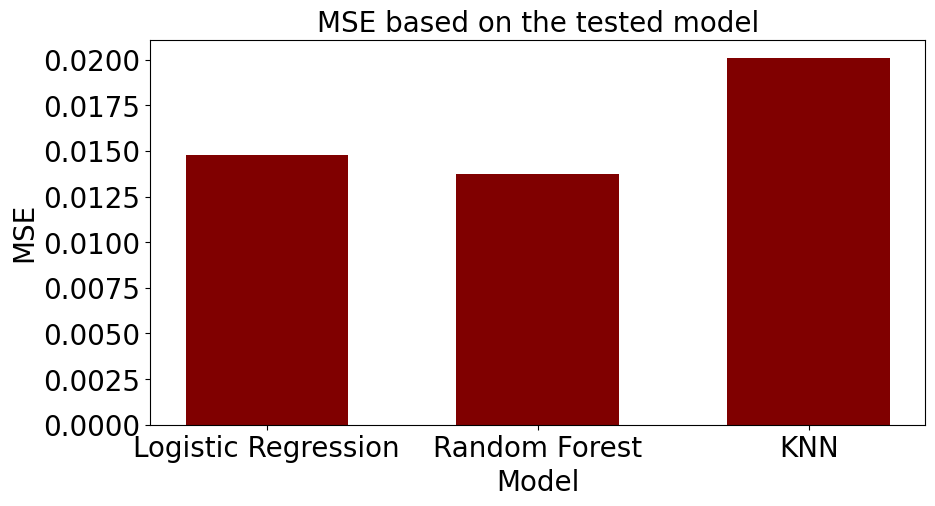

In [20]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 
 
  
# creating the dataset
data = {'Logistic Regression':mean_squared_error(pred_log, y_test), 'Random Forest':mean_squared_error(pred_rfc, y_test), 
        'KNN':mean_squared_error(pred_knn, y_test)}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon', 
        width = 0.6)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20)
plt.xlabel("Model", fontsize= 20)
plt.ylabel("MSE", fontsize= 20)
plt.title("MSE based on the tested model", fontsize=20)
plt.show()